<a href="https://colab.research.google.com/github/harshaneo17/pytorch_object_detection/blob/main/pytorchfracture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 68.6MB/s 
     |████████████████████████████████| 2.2MB 13.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20200912-cp36-none-any.whl size=43996 sha256=8cd557a828b44b73a01bcab8b43e16f246908d6e07363ad22034e43a7868a826
  Stored in directory: /root/.cache/pip/wheels/34/41/7b/f0a0b5800bea0474ae553342bde52093fdd5852764463aa2ec
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 5.3MB 8.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 112kB 45.4MB/s 
     |████████████████████████████████| 133kB 43.5MB/s 


In [ ]:

# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "harshaarya" 
os.environ['KAGGLE_KEY'] = "0a293a7d16a5498af765107e9a16047a"

In [ ]:
!kaggle datasets download -d harshaarya/robofracture

 98% 193M/198M [00:08<00:00, 38.2MB/s]
100% 198M/198M [00:08<00:00, 24.6MB/s]


In [ ]:
!unzip robofracture.zip

Streaming output truncated to the last 5000 lines.
  inflating: robofracture/train/206_jpg.rf.2291619fbab9bd514f41d9c9303ca253.xml  
  inflating: robofracture/train/206_jpg.rf.25929c44f48820d2b3fa512759b971c6.jpg  
  inflating: robofracture/train/206_jpg.rf.25929c44f48820d2b3fa512759b971c6.xml  
  inflating: robofracture/train/206_jpg.rf.299744294afd5f145760fa9a1304fa20.jpg  
  inflating: robofracture/train/206_jpg.rf.299744294afd5f145760fa9a1304fa20.xml  
  inflating: robofracture/train/206_jpg.rf.3065cd9776e8287df3a56ae92032a094.jpg  
  inflating: robofracture/train/206_jpg.rf.3065cd9776e8287df3a56ae92032a094.xml  
  inflating: robofracture/train/206_jpg.rf.3d4d6ffb9b8ddeb7706d4d53005672dc.jpg  
  inflating: robofracture/train/206_jpg.rf.3d4d6ffb9b8ddeb7706d4d53005672dc.xml  
  inflating: robofracture/train/206_jpg.rf.3deabf7b6f46ea3c34c32cb43bd488c1.jpg  
  inflating: robofracture/train/206_jpg.rf.3deabf7b6f46ea3c34c32cb43bd488c1.xml  
  inflating: robofracture/train/206_jpg.rf.4bce

In [ ]:
!ls

'=2.0.1'   drive   robofracture   robofracture.zip   sample_data


In [ ]:
import pandas as pd

df = pd.read_csv('/content/robofracture/train_labels.csv')

df.head()

filename  width  ...  xmax ymax
0  101_jpg.rf.04fa32806ee0ee219b7743866bc407e7.jpg    240  ...   240  274
1  101_jpg.rf.12e2a68fa52375e6742990a48e84c27a.jpg    253  ...   241  345
2  101_jpg.rf.15f019e739b92f821c85202ddb942026.jpg    254  ...   234  285
3  101_jpg.rf.1b2366b357da44c823d2f282d1d417af.jpg    254  ...   234  285
4  101_jpg.rf.1f170bff533c76f2cb74c48db99849b2.jpg    254  ...   234  285

[5 rows x 8 columns]

In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_robofracture_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['fracture']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['fracture']

for d in ["train", "test"]:
  DatasetCatalog.register('robofracture/' + d, lambda d=d: get_robofracture_dicts('robofracture/' + d + '_labels.csv', 'robofracture/' + d+'/'))
  MetadataCatalog.get('robofracture/' + d).set(thing_classes=classes)
robofracture_metadata = MetadataCatalog.get('robofracture/train')

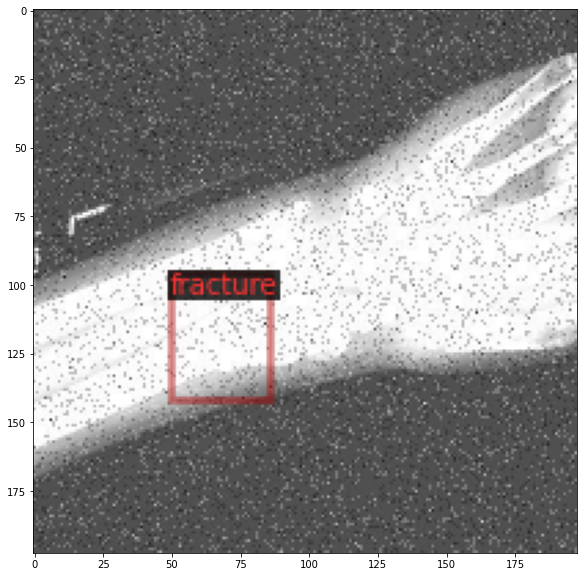

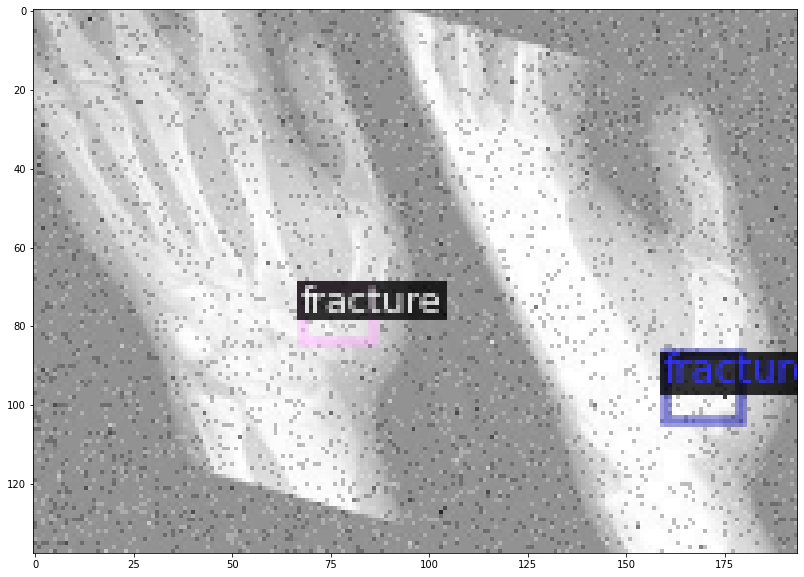

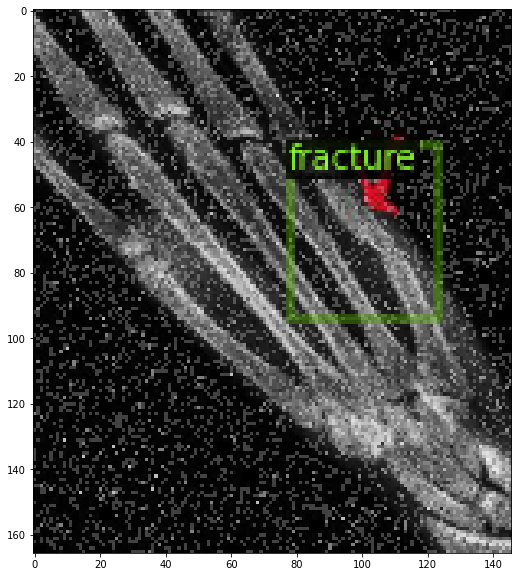

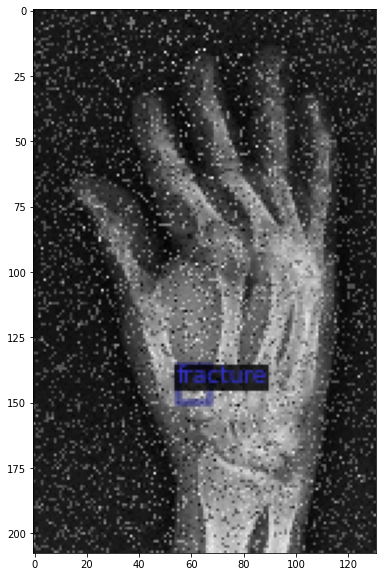

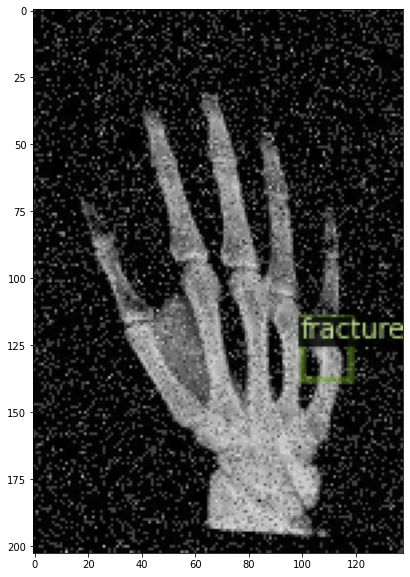

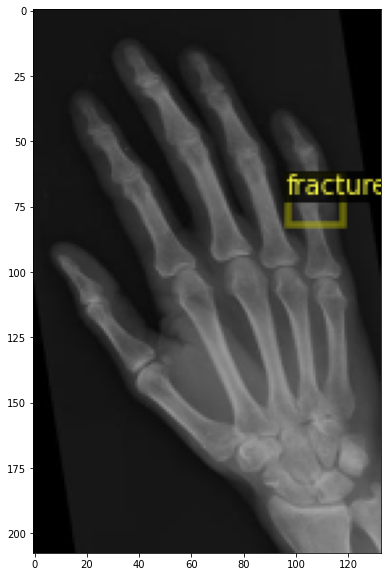

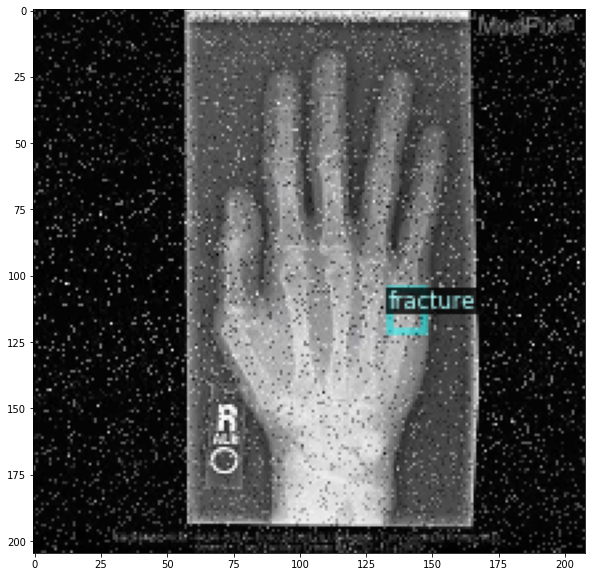

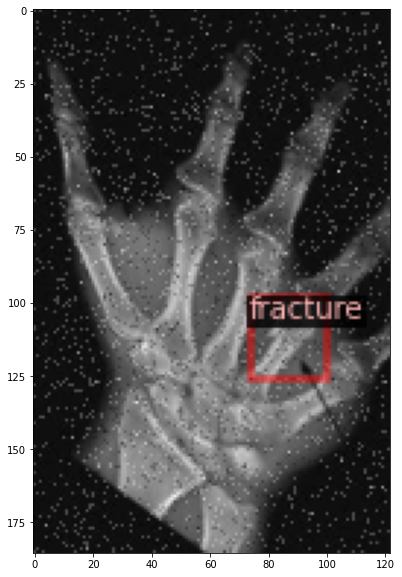

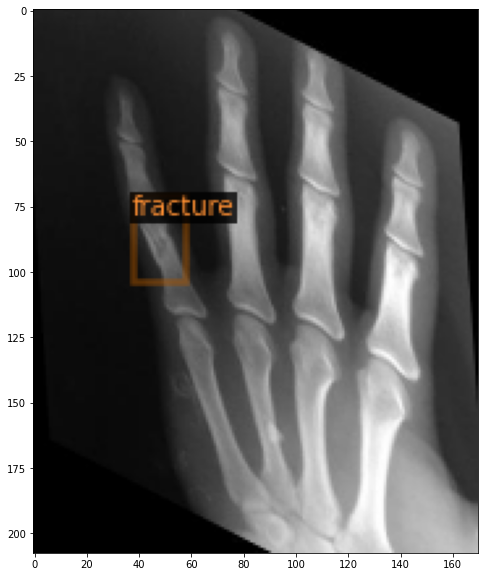

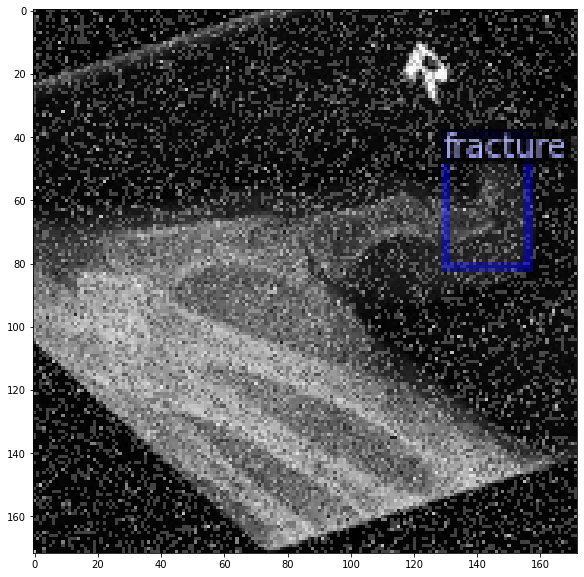

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('robofracture/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=robofracture_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('robofracture/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 8000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/21 16:40:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyboardInterrupt: ignored

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join('/content/drive/My Drive/output/' + 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('robofracture/test', )
predictor = DefaultPredictor(cfg)

In [ ]:

df_test = pd.read_csv('robofracture/test_labels.csv')
df_test

filename  width  ...  xmax ymax
0     0_jpg.rf.00b95755ac30eabc44fb2002e40edc22.jpg    250  ...   204  350
1     0_jpg.rf.013fbb3ae32a8a4dc3613550ecaece83.jpg    252  ...   181  327
2     0_jpg.rf.0449a6b1002af9177c3116bdcae6502e.jpg    252  ...   181  327
3     0_jpg.rf.0a11f4ac8b8b39283d0ccc7d96c30eaf.jpg    192  ...   173  318
4     0_jpg.rf.0eab3ff11905cd8d0c985f832ea48f18.jpg    250  ...   113  327
...                                             ...    ...  ...   ...  ...
1627  9_jpg.rf.f33673a9a970821a54cccd3044390343.jpg    412  ...   297  253
1628  9_jpg.rf.f854849017970f65dfda3cfe35837bff.jpg    128  ...    85  323
1629  9_jpg.rf.f9270665b53c77aaadef7edbf128d5c2.jpg    120  ...   120  319
1630  9_jpg.rf.fc000aa31af608f0bdfb9fd2829c07cc.jpg    268  ...   181  230
1631  9_jpg.rf.fd06d3f5cb3ab951e75266854f119e37.jpg    318  ...   223  286

[1632 rows x 8 columns]

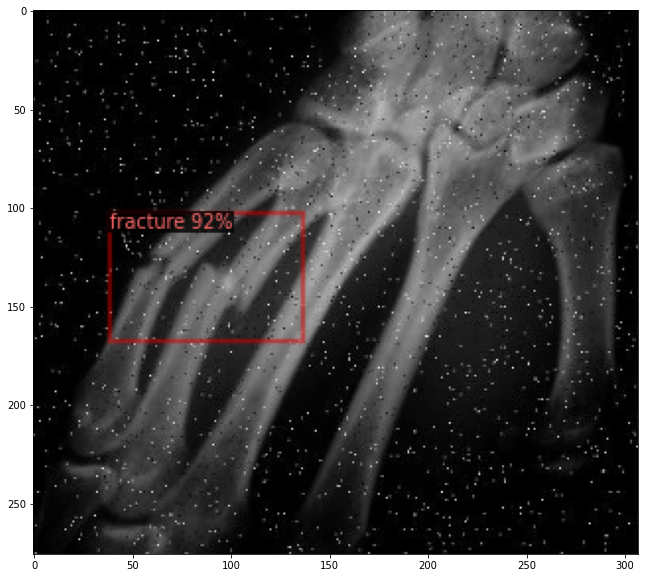

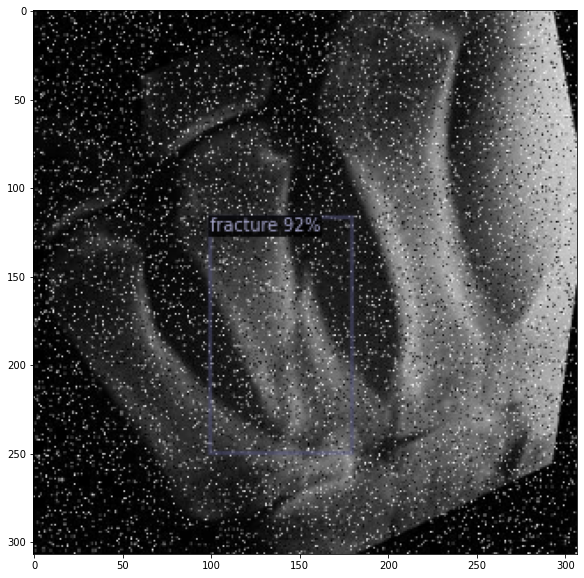

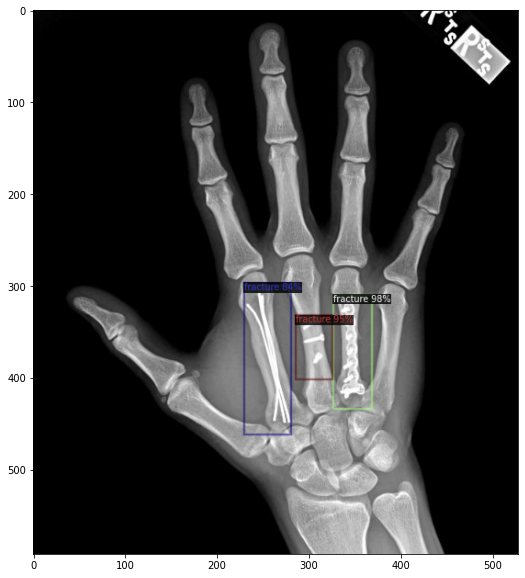

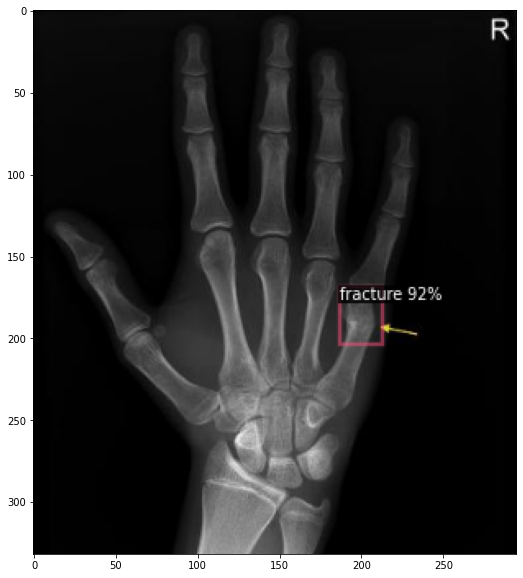

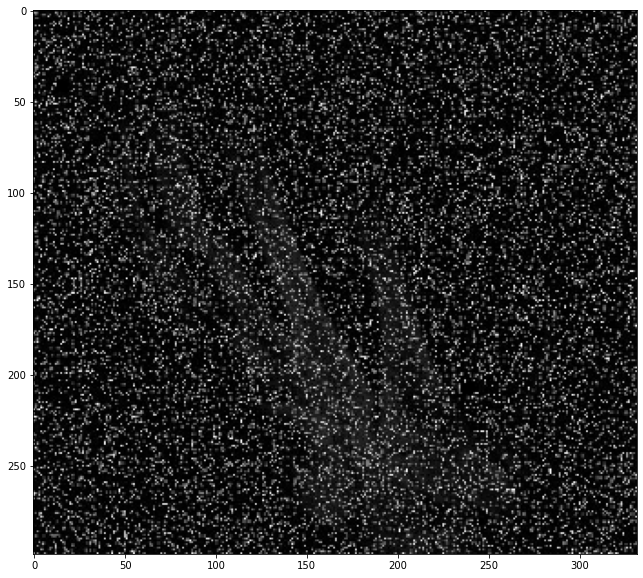

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('robofracture/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=robofracture_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
!mv '/content/output' '/content/drive/My Drive'